In [5]:
import numpy as np
import pandas as pd
#import asyncio
#import aiohttp
import json
import csv
import requests
import time
from cryptodata import get_markets, get_pairs, get_ohlc
import os
import shutil
import matplotlib.pyplot as plt

In [159]:
pd.set_option('display.max_rows',8)
def Timestamp_from_string(s='31 12 99'):
    #print(time.mktime(time.strptime(s, "%d %m %y")))
    return pd.Timestamp(time.mktime(time.strptime(s, "%d %m %y")), unit='s')

In [6]:
def get_daily_price(asset="btc", api="coinmetrics", data_type="price(usd)", start=0, end=time.time()):
    if (api == "coinmetrics"):
        try:
            url =  "https://coinmetrics.io/api/v1/get_asset_data_for_time_range/"+asset+"/"+data_type
            url = url + "/"+str(int(start)) +"/"+str(int(end))
            r = requests.get(url).json()['result']
            a = pd.DataFrame(r, columns = ['date(utc)',str(asset)+" "+str(data_type)])
            #print(url)
            a[a.columns[0]] = pd.to_datetime(a[a.columns[0]], unit = 's')

            return a
        except:
            print("Error: disfunctional API from Coinmetrics")            
            
    else:
        return 0


def get_assets_from_coimetrics():
    url = 'https://coinmetrics.io/api/v1/get_supported_assets'
    r  = requests.get(url).json()
    return r

def get_whole_market_from_coimetrics():
    assets = get_assets_from_coimetrics()
    market = {}
    print('Assets available:', assets)
    for asset in assets:
        #print('Getting data for',asset)
        market[asset] = get_daily_price(asset)
    return market

def merge_market_data(market, start=Timestamp_from_string('01 01 17')):
    '''merges the market data from the whole market, dumping coins which are too young '''
    assets = list(market.keys())
    #print(assets)
    #print(range(1,len(assets)))
    mkt = market[assets[0]]
    for i in range(1, len(assets)):
        if market[assets[i]]['date(utc)'][0] < start:
            mkt = pd.merge(mkt, market[assets[i]])
    
    return mkt


def get_coins_series(coins,start=Timestamp_from_string('01 01 17').timestamp()):
    returns = get_daily_price(coins[0], start=start)
    for i in range(1,len(coins)):
        returns = pd.merge(returns, get_daily_price(coins[i], start=start))
    return returns

 


def rate_of_return(df):
    cols = df.columns
    #print(cols)
    if (type(df[cols[0]][0]) == pd.Timestamp):
        a = df[cols[1:]].values
        b = a/a[0, :]
        df2 = pd.DataFrame(b, columns = df.columns[1:])
        #df2 = pd.merge(df2, pd.Dataframe(b, columns = cols[1:]))
        #print(b)
        
        return df2
    else:
        print('error return_from_values')

    

In [10]:
from cryptodata import *

{'binance',
 'bitbay',
 'bitfinex',
 'bitflyer',
 'bithumb',
 'bitmex',
 'bitsquare',
 'bitstamp',
 'bittrex',
 'cexio',
 'coinone',
 'cryptofacilities',
 'gdax',
 'gemini',
 'hitbtc',
 'huobi',
 'kraken',
 'luno',
 'okcoin',
 'okex',
 'poloniex',
 'qryptos',
 'quadriga',
 'quoine',
 'wex'}

In [63]:
a = get_markets()
btc = Pair('btcusd')


In [270]:
#b = list(a)
#c = list_markets_containing_pair()
def cryptowatch_summary(Pair):
    
    for exchange in list(Pair.markets):
        url = "https://api.cryptowat.ch/markets/"+exchange+"/"+Pair.name+"/summary"
        r = requests.get(url).json()
    return r

def cryptowatch_ohlc(pair_name, exchange, period=24*60*60,
                     start=Timestamp_from_string("04 01 18"),
                     end=pd.Timestamp(time.time(), unit='s')):
    
    url = "https://api.cryptowat.ch/markets/"+exchange+"/"+pair_name+"/ohlc"
    r = requests.get(url, params = {'before':int(end.timestamp()), 'after': int(start.timestamp()) }).json()
    p = pd.DataFrame(r['result'][str(period)], columns = ['date(utc)','CloseTime', 'OpenPrice', 'HighPrice', 'LowPrice', 'ClosePrice', 'Volume' ])
    p['date(utc)'] = pd.to_datetime(p['date(utc)'], unit='s')
    return p
    
#r = cryptowatch_summary(btc)

def cryptowatch_ohlc_data_for_pair(Pair, period = 24*60*60, 
                                        start = pd.Timestamp(2018, 1, 1),
                                        end=pd.Timestamp(time.time(), unit='s'),
                                        ):
    exchanges = list(Pair.markets)
    data = {}
    for ex in exchanges:
        data[ex] = cryptowatch_ohlc(Pair.name, ex, period, start, end)
    return data

def cryptowatch_volume_across_exchanges(ohlc_data, exchanges):
    data = ohlc_data[exchanges[0]][['date(utc)', 'Volume']]
    data = data.rename(index=str, columns={"date(utc)": "date(utc)", "Volume": exchanges[0]})
    for i in range(len(exchanges)):
        temp = ohlc_data[exchanges[i]][['date(utc)', 'Volume']]
        temp = temp.rename(index=str, columns={"date(utc)": "date(utc)", "Volume": exchanges[i]})
        data = pd.merge(data, temp)
    return data

def cryptowatch_closeprice_across_exchanges(ohlc_data, exchanges):
    data = ohlc_data[exchanges[0]][['date(utc)', 'ClosePrice']]
    data = data.rename(index=str, columns={"date(utc)": "date(utc)", "ClosePrice": exchanges[0]})
    for i in range(len(exchanges)):
        temp = ohlc_data[exchanges[i]][['date(utc)', 'ClosePrice']]
        temp = temp.rename(index=str, columns={"date(utc)": "date(utc)", "ClosePrice": exchanges[i]})
        data = pd.merge(data, temp)

        
        
    return data


In [317]:
btc.ohlc_data = cryptowatch_ohlc_data_for_pair(btc)


In [324]:
exchanges = list(btc.ohlc_data)
a = cryptowatch_volume_across_exchanges(btc.ohlc_data, exchanges    )
#btc.ohlc_data['wex']
b = a[a.columns[1:]].values
#b.values/b.sum(axis =1)
c = b.sum(axis = 1)
d = np.reshape(np.repeat(c,b.shape[1]), b.shape)
b/d
weights = pd.DataFrame(b/d, columns = a.columns[1:])
#weights

In [325]:
m = cryptowatch_closeprice_across_exchanges(btc.ohlc_data, exchanges)
n = m[m.columns[1:]].values
o = m[m.columns[1:]]*weights
p = o.values.sum(axis=1)
p.dtype
index = pd.DataFrame({'date(utc)':m[m.columns[0]],'index':p})
index

,date(utc),index
0,2018-06-01,10924.996054
1,2018-06-02,10753.813234
2,2018-06-03,10019.075190
3,2018-06-05,10016.016925
...,...,...
49,2018-07-23,10240.016764
50,2018-07-24,28333.117986
51,2018-07-25,38844.141722
52,2018-07-26,9715.052183


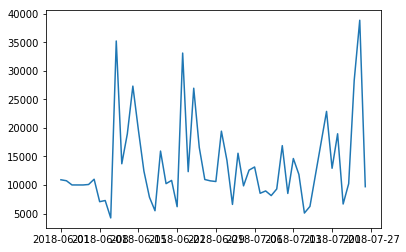

In [359]:
x = index['date(utc)']
y = index['index']
plt.plot(x,y)
#locs, labels = plt.xticks()
#plt.xticks(locs[0:9:2], labels[0:9:2])


In [18]:
def list_markets_containing_pair(pair='btcusd'):
    try:
        r = requests.get("https://api.cryptowat.ch/markets").json()['result']
        exchanges = {item['exchange'] for item in r if (item['active'] is True and item['pair'] == pair)}
        return exchanges
    except:
        print('error')

def list_pairs(pairs=get_pairs(), p1='btc'):
    pairs = list(pairs)
    L = []
    for pair in pairs:
        if p1 == pair[:len(p1)]:
            L.append(pair)
    return L

def list_pairs_in_market(market):
    r = requests.get("https://api.cryptowat.ch/markets/"+market).json()['result']
    market_pairs = {item['pair'] for item in r if item['active'] is True}
    return market_pairs

In [17]:
import os
import shutil

class Pair:
    markets = {}
    data = {}
    def __init__(self, name, start=0, end=time.time(), period=1440):
        self.name = str(name)
        self.period = period    
        self.start = start
        self.end = int(end)
        self.markets = list_markets_containing_pair(self.name)
        self.metadata = pd.DataFrame([period, start, end])
        
    

def download_pair_data(pair, force_update = False):
    try:
        os.mkdir(pair.name)
    except:
        try:
            m = pd.read_csv('pair_metadata.csv')
        except:
#        if not (m == pair.metadata).all():
            shutil.rmtree(pair.name)
            os.mkdir(pair.name)
        #print('m\n',m)
        #print('pair.metadata', pair.metadata)
        #if not (m == pair.metadata).all():
        #    shutil.rmtree(pair.name)
        #    os.mkdir(pair.name)
    
    #print(pair.markets)
    for key in list(pair.markets):
        pair.data[key].to_csv(pair.name+'/'+key+'.csv')
    
    pair.metadata.to_csv('pair_metadata.csv')

def load_pair_data(name, start = 0, end = time.time(), period = 1440):
    mkt = os.listdir(name)
    for i in range(len(mkt)):
        mkt[i] = mkt[i][0:-4]
    return mkt